In [1]:
import time
import torch
import numpy as np
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, load_val_dataset

# torch.manual_seed(1234)

lr = 1e-4
EPS = 1e-10
T=5
device = 'cpu'

In [2]:
def train_instance(model, optimizer, data, n_ants):
    model.train()
    sum_loss = 0.0
    count = 0
    for pyg_data, distances in data:
        heu_vec = model(pyg_data)
        heu_mat = model.reshape(pyg_data, heu_vec) + EPS
        
        aco = ACO(
            n_ants=n_ants,
            heuristic=heu_mat,
            distances=distances,
            device=device,
            two_opt=True,
        )
    
        costs, log_probs, paths = aco.sample()
        baseline = costs.mean()
        # reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
        costs_2opt, _ = aco.sample_2opt(paths)
        baseline_2opt = costs_2opt.mean()
        cost = (costs_2opt - baseline_2opt) * 0.8 + (costs - baseline) * 0.2
        reinforce_loss = torch.sum(cost.detach() * log_probs.sum(dim=0)) / aco.n_ants
        sum_loss += reinforce_loss
        count += 1

    sum_loss = sum_loss/count
    optimizer.zero_grad()
    sum_loss.backward()
    torch.nn.utils.clip_grad_norm_(parameters = model.parameters(), max_norm = 1.0, norm_type = 2)
    optimizer.step()

def infer_instance(model, pyg_data, distances, n_ants):
    model.eval()
    heu_vec = model(pyg_data)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat.cpu(),
        distances=distances.cpu(),
        device='cpu',
        two_opt=True,
        )
    costs = aco.sample(inference = True)[0]
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_1 = aco.run(n_iterations=1, inference = True)
    best_aco_T = aco.run(n_iterations=T-1, inference = True)
    return np.array([baseline.item(), best_sample_cost.item(), best_aco_1, best_aco_T])

In [3]:
def generate_traindata(count, n_node, k_sparse):
    for _ in range(count):
        instance = torch.rand(size=(n_node, 2), device=device)
        yield gen_pyg_data(instance, k_sparse=k_sparse, start_node=0)

def train_epoch(n_node,
                n_ants, 
                k_sparse, 
                epoch, 
                steps_per_epoch, 
                net, 
                optimizer,
                batch_size = 1,
                ):
    for _ in range(steps_per_epoch):
        train_instance(net, optimizer, generate_traindata(batch_size, n_node, k_sparse), n_ants)


@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset):
    stats = []
    for data, distances in val_dataset:
        stats.append(infer_instance(net, data, distances, n_ants))
    avg_stats = [i.item() for i in np.stack(stats).mean(0)]

    return avg_stats

In [4]:
def train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 3, test_size = None, pretrained = None):
    net = Net().to(device)
    if pretrained:
        net.load_state_dict(torch.load(pretrained, map_location=device))
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)
    val_list = load_val_dataset(n_node, k_sparse, device, start_node=0)
    if test_size is not None:
        val_list = val_list[:test_size]
    animator = Animator(xlabel='epoch', xlim=[0, epochs], figsize=(6,3),
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj. (T=1)", f"Best ACO obj. (T={T})"])
    
    stats = validation(n_ants, -1, net, val_list)
    animator.add(0, stats)
    val_results = [stats]
    
    sum_time = 0
    for epoch in range(1, epochs+1):
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, epoch, steps_per_epoch, net, optimizer, batch_size=batch_size)
        sum_time += time.time() - start
        stats = validation(n_ants, epoch, net, val_list)
        animator.add(epoch, stats)
        val_results.append(stats)
        scheduler.step()
        
    print('total training duration:', sum_time)
    
    for epoch, stats in enumerate(val_results):
        print(f'epoch {epoch}:', stats)
        
    torch.save(net.state_dict(), f'../pretrained/tsp_2opt/tsp{n_node}.pt')
    return f'../pretrained/tsp_2opt/tsp{n_node}.pt'

total training duration: 692.4482517242432
epoch 0: [7.406143007278442, 5.812061157226562, 3.8085855293273925, 3.807492878437042]
epoch 1: [7.251965055465698, 5.639922103881836, 3.8075756573677064, 3.807492878437042]
epoch 2: [6.620631432533264, 5.097771139144897, 3.807492878437042, 3.807492878437042]
epoch 3: [5.838333673477173, 4.59997810125351, 3.8074928855895998, 3.807492878437042]
epoch 4: [5.530790138244629, 4.431523387432098, 3.807492883205414, 3.807492878437042]
epoch 5: [5.310253143310547, 4.332957520484924, 3.8074928903579712, 3.807492878437042]
epoch 6: [5.170983629226685, 4.268007850646972, 3.807626099586487, 3.807492883205414]
epoch 7: [5.132366132736206, 4.246961443424225, 3.8074928951263427, 3.8074928855895998]
epoch 8: [5.128845138549805, 4.250806822776794, 3.8074928951263427, 3.8074928855895998]
epoch 9: [5.063849492073059, 4.231796283721923, 3.807492899894714, 3.807492878437042]
epoch 10: [5.047881879806519, 4.212946791648864, 3.8074928903579712, 3.807492883205414]
ep

'../pretrained/tsp_2opt/tsp20.pt'

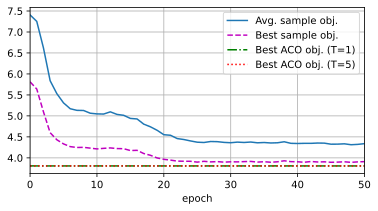

In [5]:
n_node, n_ants = 20, 100
k_sparse = 10
steps_per_epoch = 40
epochs = 50
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size=20)

In [ ]:
n_node, n_ants = 50, 30
k_sparse = 10
steps_per_epoch = 40
epochs = 20
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size=20, pretrained = '../pretrained/tsp_2opt/tsp20.pt')

total training duration: 183.70370411872864
epoch 0: [11.27510425567627, 10.150413675308227, 7.920480551719666, 7.833401865959168]
epoch 1: [10.046767091751098, 8.999756269454956, 7.882377367019654, 7.816280794143677]
epoch 2: [9.950840616226197, 8.948480105400085, 7.869833407402038, 7.810808815956116]
epoch 3: [9.890407972335815, 8.944975728988647, 7.8727604150772095, 7.817503614425659]
epoch 4: [9.895523128509522, 8.911603908538819, 7.875478339195252, 7.8149095106124875]
epoch 5: [9.851623172760009, 8.858016471862793, 7.880805897712707, 7.81720055103302]
epoch 6: [9.791707372665405, 8.82997067451477, 7.881006660461426, 7.8202577543258665]
epoch 7: [9.777973728179932, 8.84531888961792, 7.887278304100037, 7.82168032169342]
epoch 8: [9.790042905807494, 8.807004823684693, 7.8806256628036495, 7.8189250040054326]
epoch 9: [9.754736490249634, 8.82223563194275, 7.881656880378723, 7.818730311393738]
epoch 10: [9.768985376358032, 8.841232862472534, 7.8814366865158085, 7.819369373321533]
epoch 

'../pretrained/tsp_2opt/tsp100.pt'

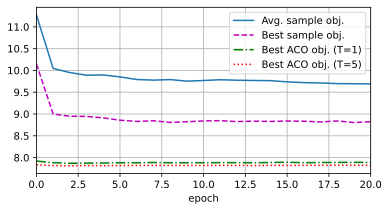

In [6]:
n_node, n_ants = 100, 30
k_sparse = 20
steps_per_epoch = 16
epochs = 20
device = 'cuda:0'
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size=10, pretrained = '../pretrained/tsp_2opt/tsp20.pt')

In [ ]:
n_node, n_ants = 200, 30
k_sparse = 40
steps_per_epoch = 16
epochs = 20
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 10, pretrained = '../pretrained/tsp_2opt/tsp20.pt')

total training duration: 835.489944934845
epoch 0: [36.199631690979004, 33.99379291534424, 17.919443321228027, 17.393197441101073]
epoch 1: [23.769001293182374, 22.01155376434326, 17.27503728866577, 17.05915594100952]
epoch 2: [23.27830810546875, 21.513143634796144, 17.23122148513794, 17.050685024261476]
epoch 3: [22.962994289398193, 21.130230808258055, 17.22432689666748, 17.056423091888426]
epoch 4: [22.834699821472167, 21.095874977111816, 17.25636758804321, 17.06735610961914]
epoch 5: [22.659065628051756, 21.08035707473755, 17.241566371917724, 17.062406253814697]
epoch 6: [22.577134609222412, 20.855384635925294, 17.24770450592041, 17.041271877288818]
epoch 7: [22.55330858230591, 20.962314128875732, 17.254839992523195, 17.054870319366454]
epoch 8: [22.460886859893797, 20.916457748413087, 17.22636651992798, 17.068374156951904]
epoch 9: [22.525351333618165, 20.95117082595825, 17.271362590789796, 17.05239133834839]
epoch 10: [22.50978422164917, 21.004512119293214, 17.25724000930786, 17.0

'../pretrained/tsp_2opt/tsp500.pt'

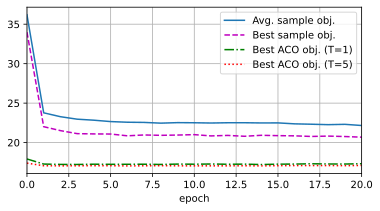

In [8]:
n_node, n_ants = 500, 40
k_sparse = 50
steps_per_epoch = 16
epochs = 20
device = 'cuda:0'
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 5, test_size=20, pretrained = '../pretrained/tsp_2opt/tsp20.pt')

In [ ]:
n_node = 1000
n_ants = 20
k_sparse = 200
steps_per_epoch = 50
epochs = 30
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 2, test_size = 10)

In [ ]:
n_node = 2000
n_ants = 20
k_sparse = 400
steps_per_epoch = 50
epochs = 30
train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, batch_size = 1, test_size = 10)